## Deliverable 1

We will follow the CRISP-DM methodology

### Business Understanding

The goal of this project is to create a regression model that can predict car prices based on its details. This includes:
- Regression Benchmarking
- Model Optimization
- Additional Insights

### Data Understanding

#### **Metadata**:

- **carID** :  An attribute that contains an identifier for each car.
- **Brand** :  The car’s main brand (e.g. Ford, Toyota).
- **model** : The car model.
- **year** : The year of Registration of the Car.
- **transmission** - Type of transmission of the car (e.g. Manual, Automatic, Semi-Automatic)
- **mileage** : The total reported distance travelled by the car (in miles).
- **tax** :  The amount of road tax (in £) that, in 2020, was applicable to the car in question. 
- **fuelType** :  Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric).
- **mpg** : Average Miles per Gallon.
- **engineSize** : Size of Engine in liters (Cubic Decimeters).
- **paintQuality%** :  The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation). 
- **previousOwners** : Number of previous registered owners of the vehicle.
- **hasDamage** :  Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not.
- **price** : The car’s price when purchased by Cars 4 You (in £).


In [1]:
# Instal RapidFuzz to perform efficient fuzzy string comparison and matching
#!pip install rapidfuzz

In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from math import ceil

# Importing process from RapidFuzz to find and rank the closest matches between strings in 'Brand', 'fuelType' snd 'transmission'
from rapidfuzz import process

# Import get_close_matches to identify and group similar words for typo correction in 'model'
from difflib import get_close_matches

In [3]:
# Import the train and test data sets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.shape

(75973, 14)

In [5]:
df_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


We can already see that we have Null Values (at least in tax) and have strange values like negative previous owners

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


Identified Problems:

- Year and previousOwners is float when it should be integer
- hasDamage should be boolean instead of float

In [7]:
features_to_check_values = ['year', 'previousOwners', 'hasDamage', 'Brand', 'model', 'transmission', 'fuelType']

for feat in features_to_check_values:
    print(f'{feat} :' )
    print(df_train[feat].unique())

year :
[2016.         2019.         2018.         2014.         2017.
 2020.         2013.                   nan 2015.         2023.36707842
 2011.         2012.         2023.1169636  2003.         2009.
 2007.         2005.         2011.11118842 2011.21085349 2023.97731126
 2004.         2010.         2010.56500919 2008.         2024.12175905
 2006.         2023.60527574 2023.38982198 2010.67696784 2001.
 2000.         2023.26798867 2010.26863473 2010.37154646 2002.
 2022.69668507 2009.81675711 2010.7464032  2012.69574039 1996.
 1998.         2022.87800554 1970.         1999.         1997.        ]
previousOwners :
[ 4.          1.         -2.34030622  3.          0.          2.
         nan -2.34565     6.25837066 -2.33512284  6.22789796  6.25823052
  6.23017958 -2.33936045  6.21772443  6.24583495 -2.29943868 -2.34010209
 -2.31225953  6.2482512  -2.31733109  6.23308217  6.24177863 -2.33744529]
hasDamage :
[ 0. nan]
Brand :
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 

In [8]:
df_train[df_train['carID']=='12786']

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage


- The year column clearly has weird values with years such as 2023.26798867, we should round them using floor.
- Previous owners has negative values and floats, we should check the number of times they appear to see if they are probably simply a mistake
- For hasDamage we only have 0 and nan, in this case nan must mean yes or no.
- For Brand, Semi-Auto and fuelType we have a lot of variations of the same name, for example Toyota and toyot.

We will deal with this in the data preparation section


In [9]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,75973.0,37986.000000,21931.660338,0.000000,18993.00,37986.0,56979.0,75972.000000
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
price,75973.0,16881.889553,9736.926322,450.000000,10200.00,14699.0,20950.0,159999.000000
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
paintQuality%,74449.0,64.590667,21.021065,1.638913,47.00,65.0,82.0,125.594308
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


The minimum in the year is 1970 which is ver far apart from the rest of the years, maybe it was an error.

We also have negative values for mileage, tax, mpg, engine_Size and previousOwners

paintQuality% is a percentage so it should not be over 100, but the max is 125.594308

From the  huge difference between Q3 and the max in a lot of features, we will probably have outliers.

In [10]:
df_train[df_train['hasDamage'] != 0]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
62,46419,Mercedes,A Class,2020.000000,26500,Semi-Auto,3500.0,Diesel,150.0,56.5,2.0,64.0,3.0,NaN
89,28739,Ford,NaN,2015.000000,7099,Manual,74176.0,Diesel,NaN,NaN,1.5,84.0,2.0,NaN
219,1768,Audi,Q3,2020.000000,35990,Semi-Auto,6000.0,Diesel,145.0,47.1,2.0,48.0,NaN,NaN
240,33860,Hyundai,Tucson,2017.000000,14600,Manual,30165.0,Diesel,30.0,61.7,1.7,55.0,4.0,NaN
304,50236,Skoda,Octavia,2014.000000,8495,Manua,65299.0,iesel,0.0,74.3,1.6,37.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75761,43016,Mercedes,C Class,2019.000000,32899,Semi-Auto,4378.0,Diesel,NaN,NaN,2.0,49.0,0.0,NaN
75788,56250,Opel,NaN,2019.000000,15495,Manual,3129.0,Petrol,145.0,39.2,1.4,49.0,0.0,NaN
75851,2693,Audi,A3,2015.000000,6793,Manual,130000.0,Diesel,0.0,74.3,1.6,51.0,3.0,NaN
75858,62623,Opel,Mokka X,2019.000000,14995,Manual,10.0,Petrol,145.0,39.2,1.4,NaN,0.0,NaN


In [11]:
df_train[(df_train['Brand'] == 'Ford') & (df_train['model'] == 'Focus') & (df_train['fuelType'] =='Petrol') & (df_train['transmission'] == 'Manual')]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
1528,31183,Ford,Focus,NaN,18495,Manual,6275.0,Petrol,150.0,60.10000,NaN,33.0,1.0,0.0
1927,21898,Ford,Focus,2015.0,9000,Manual,33917.0,Petrol,20.0,60.10000,1.0,62.0,0.0,0.0
2151,17547,Ford,Focus,2017.0,22000,Manual,36437.0,Petrol,NaN,88.32164,2.3,53.0,2.0,0.0
2492,30182,Ford,Focus,2019.0,16000,Manual,9209.0,Petrol,NaN,NaN,1.0,86.0,1.0,0.0
2982,27179,Ford,Focus,2018.0,19000,Manual,16000.0,Petrol,NaN,NaN,2.0,60.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68466,28363,Ford,Focus,2015.0,8999,Manual,20300.0,Petrol,20.0,58.90000,1.0,38.0,4.0,0.0
69983,17929,Ford,Focus,2018.0,10300,Manual,45773.0,Petrol,NaN,NaN,1.0,32.0,0.0,0.0
72327,27518,Ford,Focus,2016.0,8125,Manual,46480.0,Petrol,NaN,NaN,1.0,67.0,3.0,0.0
73179,27716,Ford,Focus,2019.0,16880,Manual,6500.0,Petrol,145.0,60.10000,1.0,47.0,4.0,0.0


In [12]:
df_train[ df_train['year'] == 1970]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
11425,62732,OPEL,Zafira,1970.0,10495,Manual,37357.0,NaN,200.0,42.2,NaN,60.0,2.0,0.0
34917,35769,Mercedes,M Class,1970.0,24999,Automatic,14000.0,Diesel,305.0,39.2,0.0,44.0,3.0,0.0


We only have 2 observations with this year, it was most likely a mistake, we will either remove this observations or replace the value with something

In [13]:
(df_train[df_train['year'] > 2020]).describe().T

,count,mean,std,min,25%,50%,75%,max
carID,358.0,38029.103352,22568.120999,102.000000,18271.500000,37679.000000,57036.750000,75877.000000
year,358.0,2023.444148,0.398203,2022.696685,2023.116964,2023.389822,2023.605276,2024.121759
price,358.0,16974.033520,9952.574090,2695.000000,10495.000000,14997.000000,21693.250000,129000.000000
mileage,353.0,22854.250488,21388.011452,-39765.602338,8004.000000,18008.000000,31469.000000,173000.000000
tax,321.0,118.606496,62.674582,-91.121630,125.000000,145.000000,145.000000,325.000000
mpg,322.0,53.952552,11.321904,21.400000,47.100000,54.300000,61.400000,88.321640
engineSize,352.0,1.639027,0.585418,-0.103493,1.200000,1.500000,2.000000,5.200000
paintQuality%,352.0,64.743431,21.033084,3.140370,46.750000,65.500000,82.000000,125.569499
previousOwners,347.0,2.009418,1.515029,-2.340306,1.000000,2.000000,3.000000,6.248251
hasDamage,353.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
df_train[ df_train['mileage'] < 0]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
268,70615,VW,Tiguan,2020.0,25000,Manual,-48190.655673,Petrol,145.0,38.2,1.5,89.0,3.0,0.0
284,43529,Mercedes,C Class,2019.0,25780,Semi-Auto,-50755.210230,Diesel,NaN,NaN,2.0,72.0,3.0,0.0
325,71090,VW,Golf,2018.0,14995,Manual,-48190.655673,Diesel,150.0,57.7,1.6,83.0,2.0,0.0
843,7845,BMW,3 Series,2019.0,23498,Semi-Auto,-58540.574478,Diesel,145.0,54.3,2.0,38.0,NaN,0.0
853,24999,Ford,FIESTA,2017.0,8895,Manual,-42650.453719,Petrol,125.0,54.3,1.2,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74961,56373,Opel,NaN,2018.0,8514,Manual,-42707.564215,Petrol,150.0,55.4,1.4,49.0,1.0,NaN
75015,45765,Mercedes,GLE Class,2020.0,54995,Automatic,-50755.210230,Diesel,150.0,32.8,3.0,69.0,4.0,0.0
75423,38413,Mercedes,SLK,2015.0,17900,Automati,-50755.210230,Diesel,150.0,56.5,2.1,40.0,3.0,0.0
75859,55820,oyota,Aygo,2019.0,8491,Manual,-39765.602338,Petrol,145.0,56.5,1.0,56.0,0.0,0.0


We have 369 observations with negative mileage, its a lot to simply remove. Since it is a distance it doesnt mae any sense for it to be negative

In [15]:
df_train[ df_train['tax'] < 0]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
26,35263,Mercedes,C Clas,NaN,11295,Automatic,45000.0,Petrol,-56.193202,46.3,1.6000,59.0,NaN,0.0
168,46204,Mercedes,C Class,2019.0,66699,Semi-Auto,630.0,Petrol,-56.193202,28.5,4.0000,32.0,2.0,0.0
360,24750,Ford,Fiesta,2019.0,17000,Manual,796.0,Petrol,-45.780610,58.9,1.0000,80.0,4.0,0.0
1051,20350,Ford,Focus,2015.0,7260,Manual,60661.0,Petrol,-45.780610,60.1,1.0000,NaN,2.0,0.0
1759,64978,Opel,Astra,2016.0,9595,Automatic,30765.0,Petrol,-20.241079,50.4,1.4000,30.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75111,11302,BMW,4 Series,2018.0,21470,Automatic,40553.0,Petrol,-43.242082,41.5,3.0000,44.0,3.0,0.0
75321,44238,Mercedes,SLK,2001.0,4990,Automatic,64476.0,Petrol,-56.193202,27.2,3.2000,47.0,3.0,0.0
75375,20309,Ford,Fiesta,2013.0,6000,Manual,48133.0,Petrol,-45.780610,54.3,2.6312,40.0,4.0,0.0
75543,33496,Hyundai,I20,2013.0,5495,Manual,30252.0,Petrol,-31.914945,57.6,1.2000,80.0,0.0,0.0


In [16]:
print(f' The number of observations with negative mileage is : {len(df_train[ df_train['mileage'] < 0])}')
print(f' The proportion of observations with negative mileage in the data set is : { round( (len(df_train[ df_train['mileage'] < 0]) / len(df_train))*100, 2)} %')


print()
print(f' The number of observations with negative tax is : {len(df_train[ df_train['tax'] < 0])}')
print(f' The proportion of observations with negative tax in the data set is : { round( (len(df_train[ df_train['tax'] < 0]) / len(df_train))*100, 2)} %')


print()
print(f' The number of observations with negative mpg is : {len(df_train[ df_train['mpg'] < 0])}')
print(f' The proportion of observations with negative mpg in the data set is : { round( (len(df_train[ df_train['mpg'] < 0]) / len(df_train))*100, 2)} %')


print()
print(f' The number of observations with negative engineSize is : {len(df_train[ df_train['engineSize'] < 0])}')
print(f' The proportion of observations with negative engineSize in the data set is : { round( (len(df_train[ df_train['engineSize'] < 0]) / len(df_train))*100, 2)} %')


print()
print(f' The number of observations with negative previousOwners is : {len(df_train[ df_train['previousOwners'] < 0])}')
print(f' The proportion of observations with negative previousOwners in the data set is : { round( (len(df_train[ df_train['previousOwners'] < 0]) / len(df_train))*100, 2)} %')

 The number of observations with negative mileage is : 369
 The proportion of observations with negative mileage in the data set is : 0.49 %

 The number of observations with negative tax is : 378
 The proportion of observations with negative tax in the data set is : 0.5 %

 The number of observations with negative mpg is : 36
 The proportion of observations with negative mpg in the data set is : 0.05 %

 The number of observations with negative engineSize is : 84
 The proportion of observations with negative engineSize in the data set is : 0.11 %

 The number of observations with negative previousOwners is : 371
 The proportion of observations with negative previousOwners in the data set is : 0.49 %


In [17]:
df_train[df_train['paintQuality%']>100]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
171,15717,Ford,Fiesta,2018.0,10491,Manual,6522.0,Petrol,145.0,65.7,1.0,125.109951,3.0,0.0
194,11200,BMW,4 Series,2019.0,23591,Semi-Auto,6100.0,Petrol,145.0,45.6,2.0,125.569499,2.0,0.0
272,53403,Toyota,Aygo,2016.0,7995,Manual,25300.0,NaN,0.0,69.0,1.0,125.594308,1.0,0.0
467,48038,Skoda,Yeti Outdoor,2015.0,11995,Semi-Auto,19805.0,Petrol,125.0,51.4,1.2,125.453599,1.0,0.0
583,10137,BMW,5 Series,2017.0,21995,Automatic,18820.0,Diesel,145.0,65.7,2.0,125.569499,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74763,75768,VW,Tiguan,2018.0,18499,Manual,24940.0,Petrol,145.0,48.7,1.4,125.366507,0.0,0.0
75073,39666,Mercede,E Class,2017.0,21602,Semi-Auto,40690.0,Diesel,145.0,NaN,3.0,125.202033,3.0,0.0
75135,23930,Ford,Fiesta,2020.0,15000,Manual,35.0,Petrol,145.0,56.5,1.0,125.109951,0.0,0.0
75540,38756,Mercedes,GLS CLASS,2016.0,36495,Semi-Auto,33000.0,Diesel,300.0,37.2,3.0,125.202033,2.0,0.0


In [18]:
print(f' The number of observations with paintQuality% higher than 100 : {len(df_train[ df_train['paintQuality%'] > 100])}')
print(f' The proportion of observations with paintQuality% higher than 100 in the data set is : { round( (len(df_train[ df_train['paintQuality%'] > 100]) / len(df_train))*100, 2)} %')

 The number of observations with paintQuality% higher than 100 : 367
 The proportion of observations with paintQuality% higher than 100 in the data set is : 0.48 %


In [19]:
df_train.describe(include='object').T

,count,unique,top,freq
Brand,74452,72,Ford,14808
model,74456,735,Focus,6353
transmission,74451,40,Manual,38050
fuelType,74462,34,Petrol,37995


Almost half of the cars are Manual, and almost half are Petrol

In [20]:
df_train.isna().sum()

carID                0
Brand             1521
model             1517
year              1491
price                0
transmission      1522
mileage           1463
fuelType          1511
tax               7904
mpg               7926
engineSize        1516
paintQuality%     1524
previousOwners    1550
hasDamage         1548
dtype: int64

We have missing values in all the columns except for carID and price

In [21]:
df_train.duplicated().sum()

np.int64(0)

We have zero duplicates overall. We should also check if we have duplicates in the carID

In [22]:
df_train.duplicated(subset='carID').sum()

np.int64(0)

We also have 0 carID duplicates

In [23]:
df_train.groupby('Brand')['price'].mean().sort_values()

Brand
TOYOT        6690.000000
opel         9878.236364
OPEL        10084.710059
Opel        10368.416888
for         10560.857143
                ...     
mercedes    24820.666667
MERCEDE     27494.250000
mw          29447.500000
ERCEDES     31691.666667
ud          34646.666667
Name: price, Length: 72, dtype: float64

In [24]:
df_train['Brand'].value_counts(normalize=True, sort=True)

Brand
Ford        0.198893
Mercedes    0.144442
VW          0.131360
Opel        0.116115
BMW         0.093591
              ...   
OYOTA       0.000027
SKOD        0.000013
TOYOT       0.000013
skod        0.000013
toyot       0.000013
Name: proportion, Length: 72, dtype: float64

In [25]:
categorical_features = ['Brand', 'model', 'transmission', 'fuelType' ]
numeric_features = df_train.columns.drop(categorical_features).drop('carID')

#### Visualizations

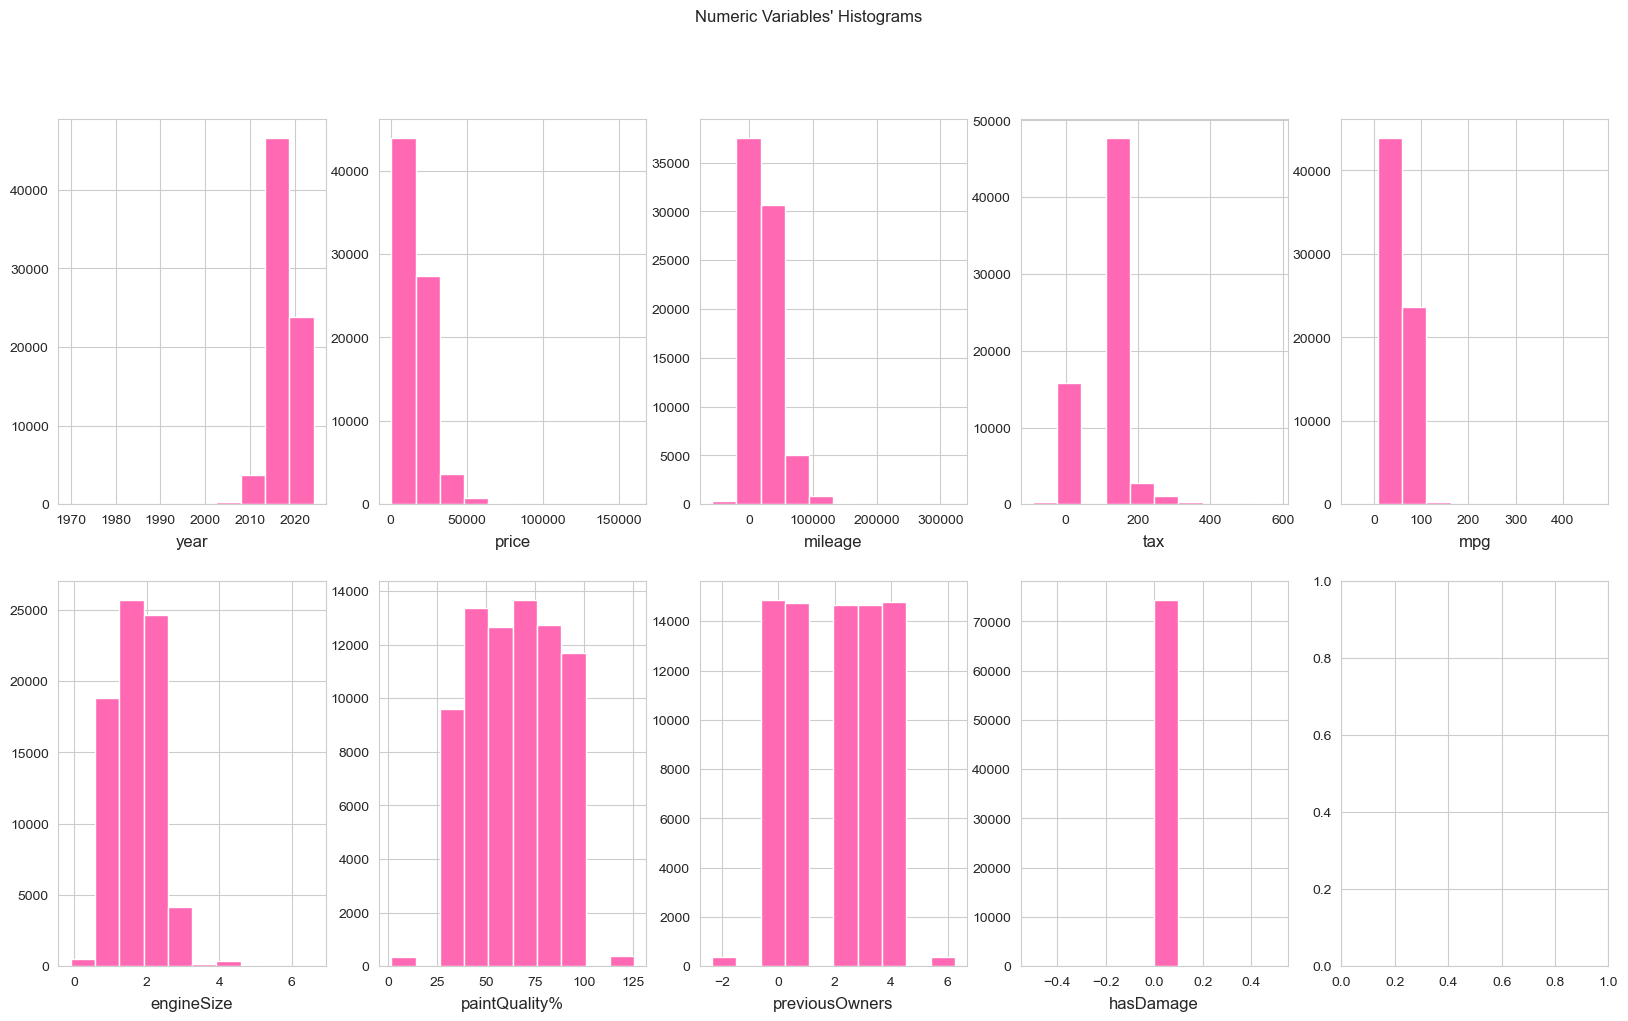

In [26]:
sns.set_style('whitegrid')

# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_features) / 2 ), figsize = (20, 11))

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(df_train[feat], color = 'hotpink')
    ax.set_title(feat, y = -0.13)

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Histograms")

plt.show()


- CarID has a uniform distribuition, starting at 0
- the majority of the distribuition for year is concentrated in 2010-2024, we probably have low outliers.


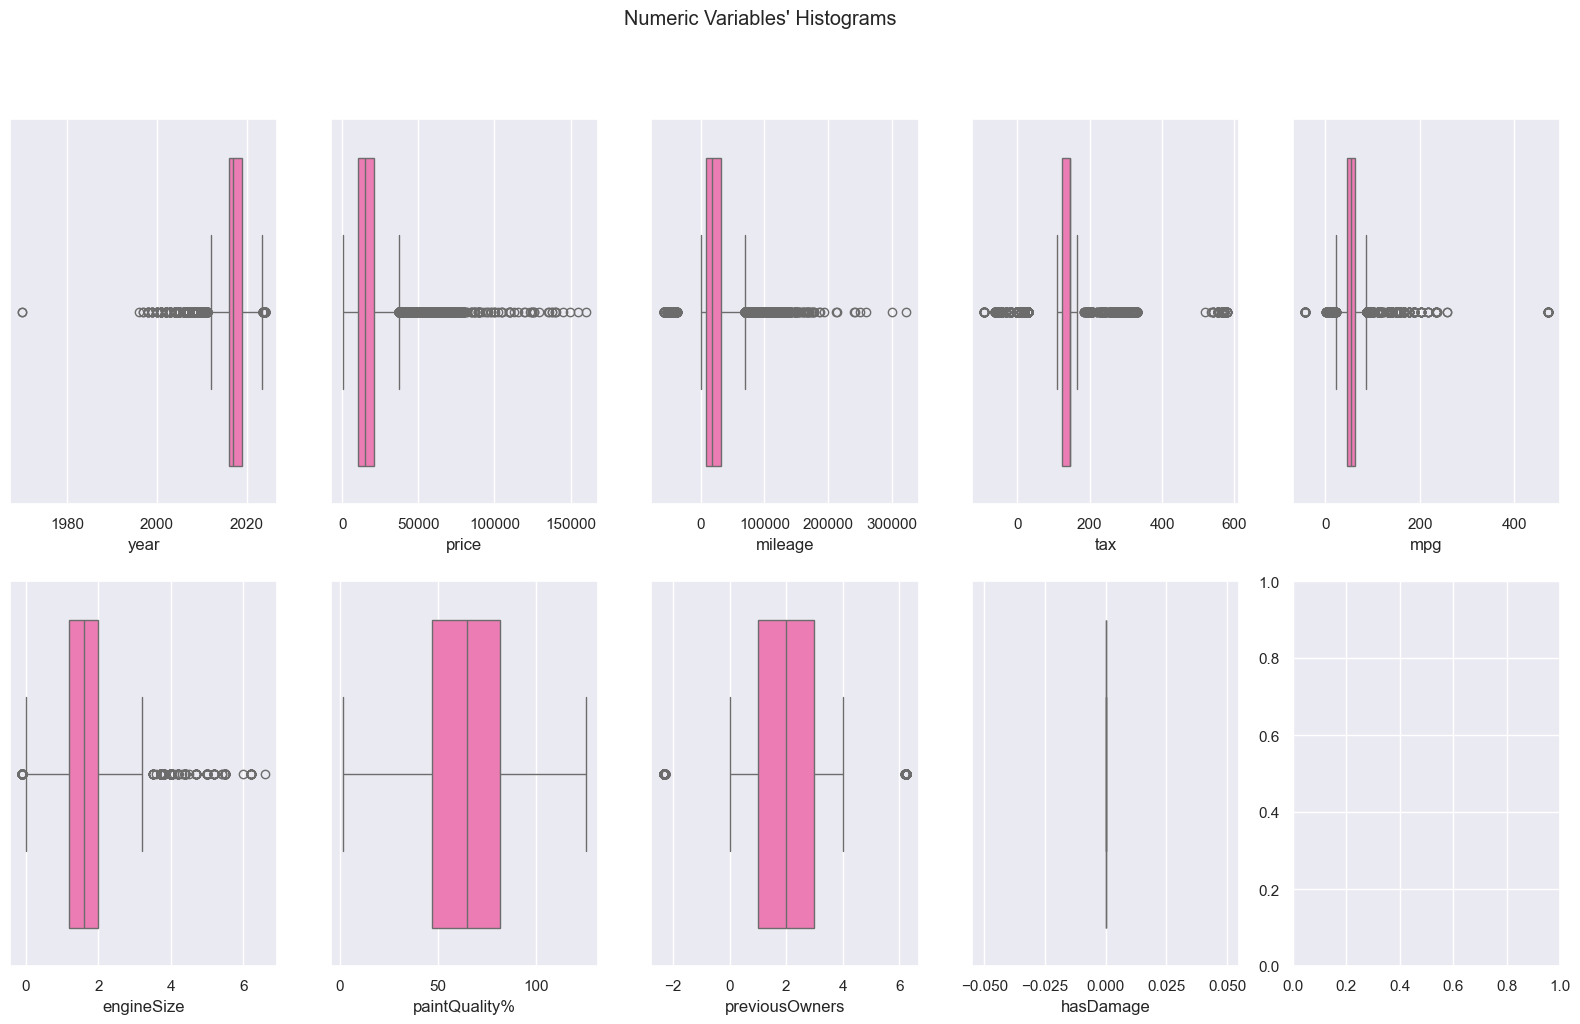

In [27]:
sns.set()

# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_features) / 2 ), figsize = (20, 11))

for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=df_train[feat], ax=ax, color='hotpink')

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Histograms")

plt.show()

CarID, paintQuality% and hasDamage appear to be the only features without outliers. hasDamage is a straight line only since it only has 0 ou NA.

The remaining features have a lot of outliers, and very extreme ones since the distribuition is very compressed.

In [28]:
# # Obtain correlation matrix. 
# Round to 2 decimal places

corr = df_train[numeric_features].corr(method="spearman")

corr = corr.round(2)
corr


,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
year,1.00,0.60,-0.78,0.32,-0.31,-0.04,0.00,0.00,NaN
price,0.60,1.00,-0.51,0.31,-0.39,0.56,0.00,-0.00,NaN
mileage,-0.78,-0.51,1.00,-0.25,0.32,0.10,-0.00,0.00,NaN
tax,0.32,0.31,-0.25,1.00,-0.55,0.16,0.00,-0.00,NaN
mpg,-0.31,-0.39,0.32,-0.55,1.00,-0.20,0.00,0.00,NaN
engineSize,-0.04,0.56,0.10,0.16,-0.20,1.00,0.00,0.00,NaN
paintQuality%,0.00,0.00,-0.00,0.00,0.00,0.00,1.00,-0.01,NaN
previousOwners,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.01,1.00,NaN
hasDamage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


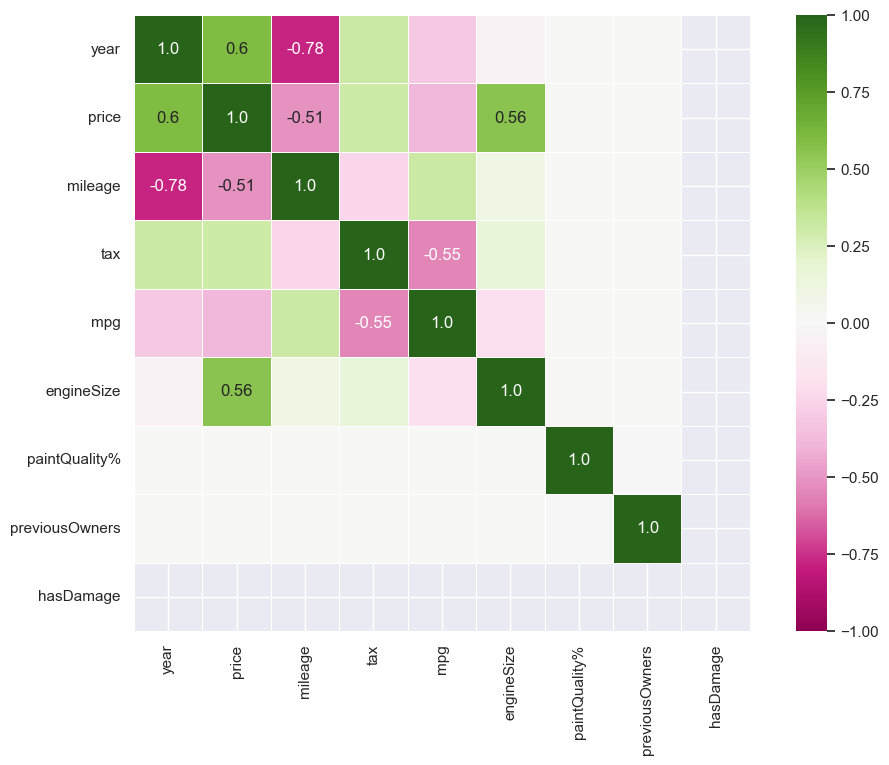

In [29]:

# Prepare figure
fig = plt.figure(figsize=(12, 8))

# percebr melhor o que está a acontecer aqui
mask_annot = np.absolute(corr.values) >= 0.5 
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 


# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, 
            annot=annot, # Specify custom annotation
            fmt='s', # The annotation matrix now has strings, so we need to explicitly say this
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='PiYG' # Diverging color map
            )

# ## Once you are happy, save this as an image
# # plt.savefig(os.path.join('..', 'figures', 'eda', 'correlation_matrix.png'), dpi=200)

plt.show()

# ## How can we improve this figure?

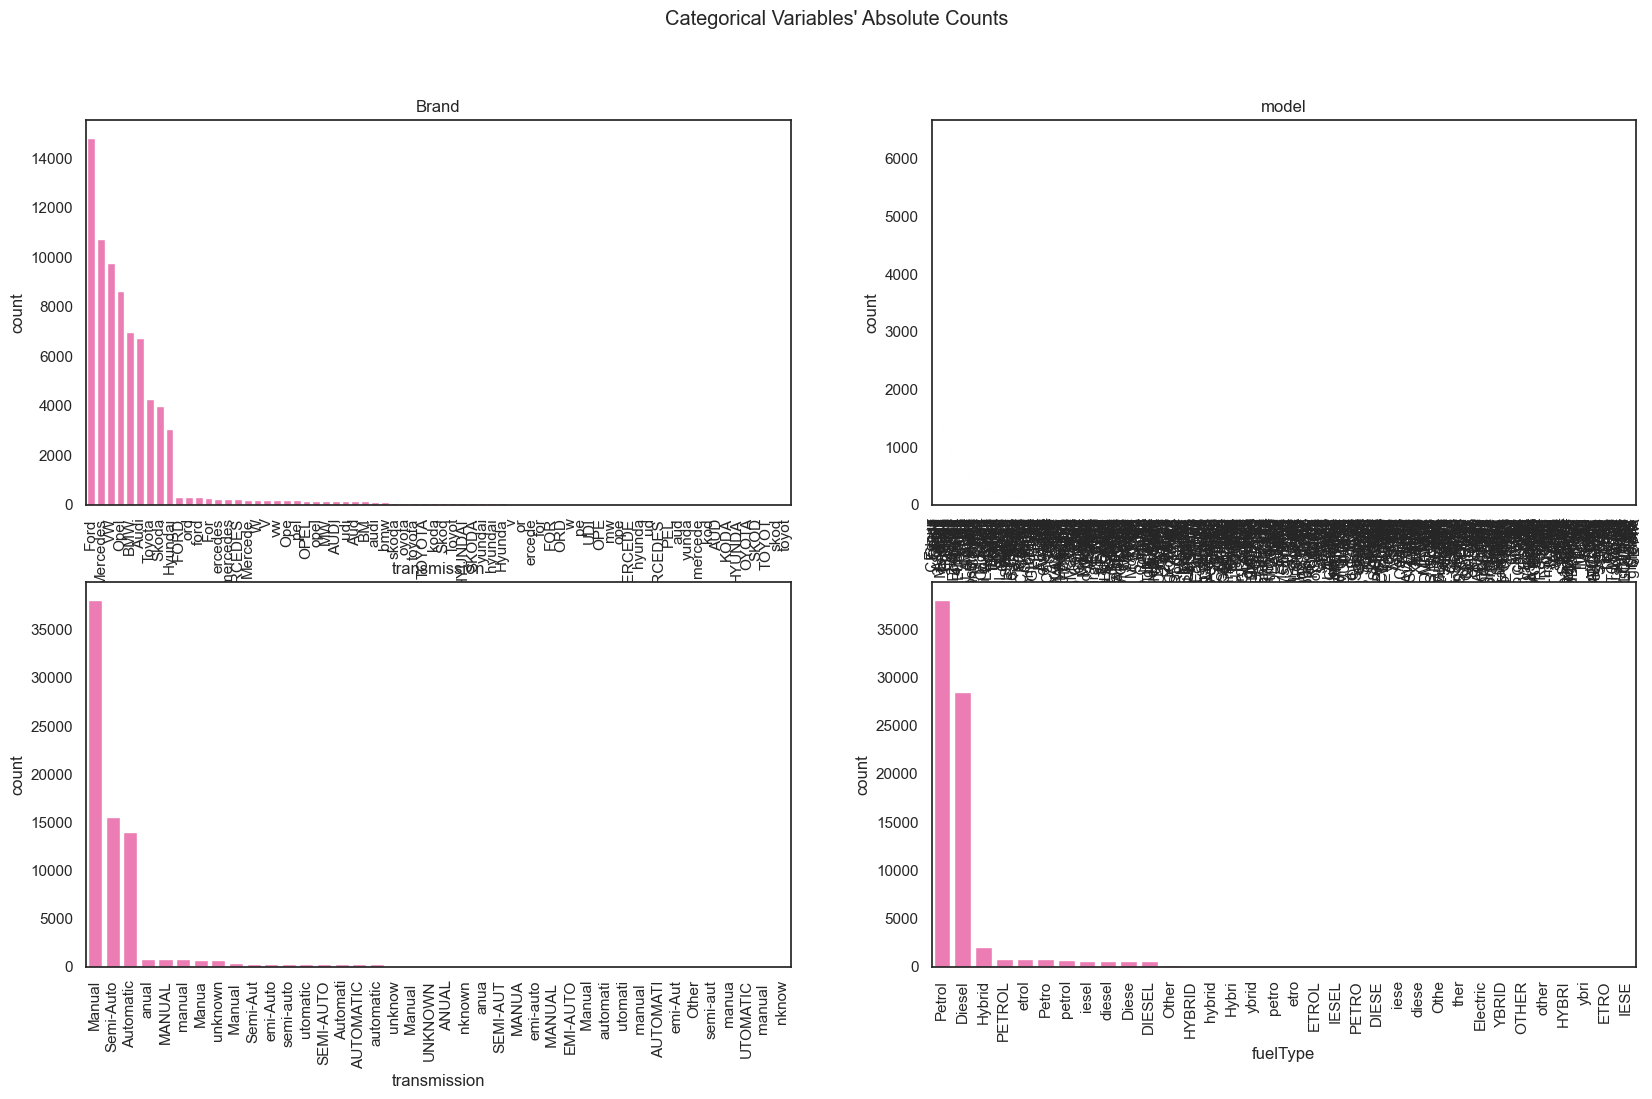

In [30]:
sns.set(style="white")

fig, axes = plt.subplots(
    2, 
    ceil(len(categorical_features) / 2), 
    figsize=(20, 11)
    )

for ax, feat in zip(axes.flatten(), categorical_features):
    sns.countplot(x=df_train[feat], ax=ax, 
                  order=df_train[feat].value_counts().index, color = 'hotpink') 
    ax.set_title(feat)
    ax.tick_params(axis='x', rotation=90)  # roda os labels no eixo x


plt.suptitle("Categorical Variables' Absolute Counts")
plt.show()

With these plots we can visualize the problems in these columns, the huge amount of classes, most with very low frequency and simillar names.

### Data Preparation

What we will have to do based on the insights from the Data Understanding:
- Fix the name differences of the categorical variables
- Fix the negative numbers in the numerical variables
- Deal with the observations with paintQuality% higher than 100
- Round the values in year
- Drop the observations with the year 1970
- Transform hasDamage into a boolean
- Deal with missing values

Coisas a fazer:
- aprender a corrigir model e brand com difflib
- corrigir missing values em model e brand: 
    - em model agrupamos a brand dele e colocamos a moda
    - em brand pegamos no modelo e vamos ao data set e a primeira vez que aparecer o modelo pegamos nessa brand
- juntar todos os erros de valores negativos
- eliminar as observações acima de 2020 no ano
- ver se no previous owners se as observações acima de 6 são parecidas
- ver se as observações de paintQuality acima de 100 são similares às de 100, se for substituir por 100, se não for trocar por NA
- carros automaticos não têm mpg logo se tiverem NA passa para Unkown. Os carros atuais têm por volta de 50 mpg.
 Ver valores menor que 10 e maiores do que 60/70, porque nao é possivel.
    

 <div style="background-color:#4169e1; padding: 15px; border-left: 5px solid #e75480; margin-bottom: 15px;">
 Fix categorical variables
 

Column 'Brand'

In [31]:
def correct_brand_w(df, brand, model):

    '''
    The function will switch the observations 'w' and 'W' with 'BMW' and 'VW' depending on the correspondence of their
    models in other observations. This function is only applied to one element, one brand and the corresponding model

    Parameters
    -----------
    df : DataFrame
        the DataFrame whose columns are to be fixed
        
    brand : string
        the brand 

    model : string
        the corresponding model

    
    Returns
    -----------
    brand : string
        correct model, which will be 'BMW' or 'VW' if the brand is 'w' or 'W', and the input brand otherwise
    

    '''

    # If the brand in lower case is 'w' and its a string
    if isinstance(brand, str) and brand.lower() == 'w':

        # For cicle to go over the brands and corresponding models in the DataFrame
        for brand_in_column, model_in_column in zip(df['Brand'], df['model']):

            # If the same model is found, then return the corresponding brand
            if isinstance(brand_in_column, str) and model_in_column == model and brand_in_column.lower() != 'w':
                return brand_in_column
            
    # If the brand is not 'w' or 'W', it remains the same           
    return brand

In [32]:
# Correct the 'w' and 'W' values in the columns 'Brand' by applying the function correct_brand_w to all elements in the column
df_train['Brand'] = df_train.apply(lambda row: correct_brand_w(df_train, row['Brand'], row['model']), axis = 1)

In [33]:
df_train[df_train['Brand']=='w']

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage


In [34]:
df_train[df_train['Brand']=='W']

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
13087,65456,W,NaN,2019.0,16500,Manual,3000.0,Diesel,145.0,57.7,1.6,38.0,2.0,0.0
46068,74210,W,NaN,2019.0,19450,Semi-Auto,3700.0,Diesel,145.0,52.3,2.0,87.0,3.0,0.0
53620,66941,W,NaN,2019.0,26310,Automatic,6000.0,NaN,145.0,37.7,1.5,70.0,3.0,0.0


We can see that we fixed the problem with the brand 'w' except for the cases with null values and for Caddy Maxi, which are only 4 observations. The ones that were fixed were all 'VW' so we will assume the same for these four.

In [35]:
df_train.loc[
    df_train['Brand'] =='W' ,
    'Brand'
] = 'VW'

df_train[df_train['Brand'] =='W']

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage


In [36]:
def get_similar_column_groups(df_train, column):
    
    '''
    This function receiveis the data set and the name of one of the categorical variables, and is going to return a list of 
    lists, where each sublist represents a group of similar words from that column. We will later use this groups to fix the 
    errors/typos in the column


    Parameters:
    -----------
    df_train : DataFrame
        The data set

    column : string
        Name of the column of the data set, whose observations are to be fixed
    
        
    Returns:
    -----------
     similar_groups : List  
        List with sublist that correspond to groups of similar words from the column ( represent the same word)


    '''
    # Take the column, remove NA, put all remaining observations in uppercase, remove spaces at the beggining 
    # and end of the string. Take only the unique values and put them in a list. These are the values we want to group.
    column_values = df_train[column].dropna().str.upper().str.strip().unique().tolist()

    # This list, which starts as an empty list, will store the similar groups of strings
    similar_groups = []

    # Start a for loop that will go over all the values column_values
    for value in column_values:

        # Takes all the values in the sublists of similar_groups and put them in a single list
        similar_groups_flat = [item for sublist in similar_groups if sublist is not None for item in sublist]

        if value in similar_groups_flat :

            # If the value is already in similar_groups_flat, then it already has its similarity group, no need to serach for more
            continue
        
        else:

            # Calculate the similarity between value and the other non NA observations in the column and keep the ones with a similarity higher than 80
            best_matches = process.extract(value, column_values, score_cutoff=80)

            # process.extract returns for each observation the match, the score of similarity and the index ( the position of the match in the list). Only the match is needed
            column_best_matches = [match[0] for match in best_matches]

            # Add the close matches to the list of similar groups
            similar_groups.append(column_best_matches)

    return similar_groups

# Get the groups of similar words in the column 'Brand'
similar_brands = get_similar_column_groups(df_train, 'Brand')
similar_brands
    


[['VW', 'V'],
 ['TOYOTA', 'TOYOT', 'OYOTA'],
 ['AUDI', 'UD', 'UDI', 'AUD'],
 ['FORD', 'OR', 'FOR', 'ORD'],
 ['BMW', 'MW', 'BM'],
 ['SKODA', 'KOD', 'KODA', 'SKOD'],
 ['OPEL', 'PE', 'OPE', 'PEL'],
 ['MERCEDES', 'MERCEDE', 'ERCEDES', 'ERCEDE'],
 ['HYUNDAI', 'YUNDAI', 'HYUNDA', 'YUNDA']]

In [37]:
def correct_column(value, similar_groups):

    '''

    This function will correct element wise the typos by choosing the correct version of the value. The correct version
    is found in the similarity group of the column. If the model is already corrected, it will not change


    Parameters :
    -----------
    value : string
        Element to be corrected

    similar_groups : List 
         List with sublist that correspond to groups of similar words from the column. Obtained in the function above.


    Returns :
    -----------
    value : string 
        Corrected value

        
    '''

    # If the value is NA then dont change anything
    if pd.isna(value):
        return value
    
    # Put the value in upper case and remove spaces in the begginging and end of the string
    value = value.upper().strip()

    # Go over the sublists in similar_groups, the word similarity groups
    for group in similar_groups:

        # Find the group that has value in it
        if value in group :

            # Return the match that is the longest, since it will be the complete one
            return max(group, key=len) 
        
    return value

df_train['Brand'] = df_train['Brand'].apply(lambda x: correct_column(x, similar_brands))
df_train

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,TOYOTA,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,AUDI,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,FORD,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,MERCEDES,C Class,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
75969,6265,AUDI,Q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
75970,54886,TOYOTA,Aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0
75971,860,AUDI,Q3,2015.0,12990,Manual,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0


In [38]:
df_train['Brand'].unique()

array(['VW', 'TOYOTA', 'AUDI', 'FORD', 'BMW', 'SKODA', 'OPEL', 'MERCEDES',
       'HYUNDAI', nan], dtype=object)

Column 'transmission'

In [39]:
similar_groups_transmission = get_similar_column_groups(df_train, 'transmission')
similar_groups_transmission

[['SEMI-AUTO', 'SEMI-AUT', 'EMI-AUTO', 'EMI-AUT'],
 ['MANUAL', 'ANUAL', 'MANUA', 'ANUA'],
 ['AUTOMATIC', 'AUTOMATI', 'UTOMATIC', 'UTOMATI'],
 ['UNKNOWN', 'UNKNOW', 'NKNOWN', 'NKNOW'],
 ['OTHER']]

In [40]:
df_train['transmission'] = df_train['transmission'].apply(lambda x: correct_column(x, similar_groups_transmission))
df_train

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,SEMI-AUTO,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,TOYOTA,Yaris,2019.0,13790,MANUAL,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,AUDI,Q2,2019.0,24990,SEMI-AUTO,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,FORD,FIESTA,2018.0,12500,MANUAL,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,MANUAL,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,MERCEDES,C Class,2015.0,13498,MANUAL,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
75969,6265,AUDI,Q3,2013.0,12495,SEMI-AUTO,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
75970,54886,TOYOTA,Aygo,2017.0,8399,AUTOMATIC,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0
75971,860,AUDI,Q3,2015.0,12990,MANUAL,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0


In [41]:
df_train['transmission'].unique()

array(['SEMI-AUTO', 'MANUAL', 'AUTOMATIC', nan, 'UNKNOWN', 'OTHER'],
      dtype=object)

Column 'fuelType'

In [42]:
similar_groups_fuelType = get_similar_column_groups(df_train, 'fuelType')
similar_groups_fuelType

[['PETROL', 'ETROL', 'PETRO', 'ETRO'],
 ['DIESEL', 'IESEL', 'DIESE', 'IESE'],
 ['HYBRID', 'HYBRI', 'YBRID', 'YBRI'],
 ['OTHER', 'THER', 'OTHE'],
 ['ELECTRIC']]

In [43]:
df_train['fuelType'] = df_train['fuelType'].apply(lambda x: correct_column(x, similar_groups_fuelType))
df_train

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,SEMI-AUTO,28421.0,PETROL,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,TOYOTA,Yaris,2019.0,13790,MANUAL,4589.0,PETROL,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,AUDI,Q2,2019.0,24990,SEMI-AUTO,3624.0,PETROL,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,FORD,FIESTA,2018.0,12500,MANUAL,9102.0,PETROL,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,MANUAL,1000.0,PETROL,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,MERCEDES,C Class,2015.0,13498,MANUAL,14480.0,PETROL,125.0,53.300000,2.0,78.0,0.000000,0.0
75969,6265,AUDI,Q3,2013.0,12495,SEMI-AUTO,52134.0,DIESEL,200.0,47.900000,2.0,38.0,2.000000,0.0
75970,54886,TOYOTA,Aygo,2017.0,8399,AUTOMATIC,11304.0,PETROL,145.0,67.000000,1.0,57.0,3.000000,0.0
75971,860,AUDI,Q3,2015.0,12990,MANUAL,69072.0,DIESEL,125.0,60.100000,2.0,74.0,2.000000,0.0


In [44]:
df_train['fuelType'].unique()

array(['PETROL', 'DIESEL', 'HYBRID', nan, 'OTHER', 'ELECTRIC'],
      dtype=object)

Column 'model'

Process.extract from the library rapidfuzz wasnt able to group the same models in the column 'model', so for this case we will use get_close_matches from difflib.

In [45]:
def get_prefix(model):
    # Take the prefix or the first letter of the model
    return model.split(" ")[0]


def similar_models(df_train):
    
    '''
    This function receiveis the data set and is going to return a list of lists, where each sublist represents a 
    group of similar models. We will later use this groups to fix the errors in the 'models' column


    Parameters:
    -----------
    df_train : DataFrame
        The data set
    
        
    Returns:
    -----------
     similar_groups : List  
        List with sublist that correspond to groups of similar words (brands)


    '''
    
    # Take the 'model' column, remove NA, put all remaining observations in uppercase, remove spaces at the beggining 
    # and end of the string. Take only the unique values and put them in a list. These are the values we want to group.
    models = df_train['model'].dropna().str.upper().str.strip().unique().tolist()

    # This list, which starts as an empty list, will store the similar groups of strings
    similar_groups = []
    
    # Start a for loop that will go over all the values in models
    for model in models:

        # Transform de list of lists in a unique list with all the values in the sublists
        similar_groups_flat = [item for sublist in similar_groups if sublist is not None for item in sublist]

        if model in similar_groups_flat:

            # If the model is already in similar_groups_flat, then it already has its similarity group, no need to serach for more
            continue
        else:
             
             # Calculate the similarity between model and the other observations and keep the ones with a similarity higher than 0.85
             close_matches = get_close_matches(model, models, cutoff=0.85)

             model_prefix = get_prefix(model)
             
             # For the models with more than one word it is necessary to evaluate the prefix in order to separate them well
             if " " in model:

                # Only keep the models with the same model code/ prefix. Different model codes belong to different models
                close_matches = [match for match in close_matches if get_prefix(match) == model_prefix]

            # Add the close matches to the list of similar groups
             similar_groups.append(close_matches)

    return similar_groups

# Get the similar words in the column 'model'
similar_models = similar_models(df_train)
similar_models

[['GOLF', 'GOL'],
 ['YARIS', 'YARI'],
 ['Q2'],
 ['FIESTA', 'FIEST'],
 ['2 SERIES', '2 SERIE'],
 ['3 SERIES', '3 SERIE'],
 ['A3'],
 ['OCTAVIA', 'OCTAVI'],
 ['PASSAT', 'PASSA'],
 ['FOCUS', 'FOCU'],
 ['INSIGNIA', 'INSIGNI'],
 ['A CLAS', 'A CLASS'],
 ['Q3'],
 ['FABIA', 'FABI'],
 ['KA+'],
 ['GLC CLASS', 'GLC CLAS'],
 ['I30'],
 ['C CLASS', 'C CLAS'],
 ['POLO', 'POL'],
 ['E CLASS', 'E CLAS'],
 ['Q5'],
 ['UP'],
 ['C-HR', 'C-H'],
 ['MOKKA X'],
 ['CORSA', 'CORS'],
 ['ASTRA', 'ASTR'],
 ['TT'],
 ['5 SERIES', '5 SERIE'],
 ['AYGO', 'AYG'],
 ['4 SERIES', '4 SERIE'],
 ['SLK'],
 ['VIVA', 'VIV'],
 ['T-ROC', 'T-RO'],
 ['ECOSPORT', 'ECOSPOR'],
 ['TUCSON', 'TUCSO'],
 ['X-CLASS', 'X-CLAS'],
 ['CL CLASS'],
 ['IX20', 'IX2', 'I20'],
 ['RAPID', 'RAPI'],
 ['A1'],
 ['AURIS', 'AURI'],
 ['SHARAN', 'SHARA'],
 ['ADAM', 'ADA'],
 ['X3'],
 ['A8'],
 ['GLS CLASS', 'GLS CLAS'],
 ['B-MAX', 'B-MA'],
 ['A4'],
 ['KONA', 'KON'],
 ['I10'],
 ['MOKKA', 'MOKK'],
 ['S-MAX', 'S-MA'],
 ['X2'],
 ['CROSSLAND X', 'CROSSLAND'],
 ['TIGUAN'

In [46]:
# Function to correct element wise the column 'model'
def correct_column_model(model, similar_groups):

    '''

    This function will correct element wise the typos by choosing the correct version of the model. The correct version
    is found in the similarity group of the model. If the model is already corrected, it will not change


    Parameters :
    -----------
    model : string
        Element to be corrected

    similar_groups : List 
         List with sublist that correspond to groups of similar words (brands). Obtained in the function above.


    Returns :
    -----------
    model : string 
        Corrected brand

        
    '''

    # If the element is NA or an empty string then nothing is changed
    if pd.isna(model) or model == ' ':
        return model
    
    # If the model has only one character then it is not possible to associate it with any model so return NA
    elif len(model) == 1:
        return np.nan
    
    # Put the model in upper case and remove spaces in beggining or end of the string
    model = model.upper().strip()

    # Go over all the sublists in similar_groups, the word similarity groups
    for group in similar_groups:

        # Find the group which contains model
        if model in group :

            # Return the match that is the longest, since it will be the complete one ( in our data set we dont have typos because of more characters, it is always beacause of less)
            return max(group, key=len) 
        
    return model

# Change the column 'model' by applying the function to all elements in the column
df_train['model'] = df_train['model'].apply(lambda x: correct_column_model(x, similar_models))

In [47]:
df_train['model'].unique()

array(['GOLF', 'YARIS', 'Q2', 'FIESTA', '2 SERIES', '3 SERIES', 'A3',
       'OCTAVIA', 'PASSAT', 'FOCUS', 'INSIGNIA', 'A CLASS', 'Q3', 'FABIA',
       'KA+', 'GLC CLASS', 'I30', 'C CLASS', 'POLO', 'E CLASS', 'Q5',
       'UP', 'C-HR', 'MOKKA X', 'CORSA', 'ASTRA', 'TT', '5 SERIES',
       'AYGO', '4 SERIES', 'SLK', 'VIVA', 'T-ROC', 'ECOSPORT', 'TUCSON',
       nan, 'X-CLASS', 'CL CLASS', 'IX20', 'RAPID', 'A1', 'AURIS',
       'SHARAN', 'ADAM', 'X3', 'A8', 'GLS CLASS', 'B-MAX', 'A4', 'KONA',
       'I10', 'MOKKA', 'S-MAX', 'X2', 'CROSSLAND X', 'TIGUAN', 'A5',
       'GLE CLASS', 'ZAFIRA', 'IONIQ', 'A6', 'MONDEO', 'YETI OUTDOOR',
       'X1', 'SCALA', 'S CLASS', '1 SERIES', 'KAMIQ', 'KUGA',
       'TOURNEO CONNECT', 'Q7', 'GLA CLASS', 'ARTEON', 'SL CLASS',
       'SANTA FE', 'GRANDLAND X', 'I800', 'RAV4', 'TOURAN', 'CITIGO',
       'ROOMSTER', 'PRIUS', 'COROLLA', 'B CLASS', 'Q', 'KODIAQ',
       'V CLASS', 'CADDY MAXI LIFE', 'SUPERB', 'GETZ', 'COMBO LIFE',
       'BEETLE', 'GALAXY', 'M3'

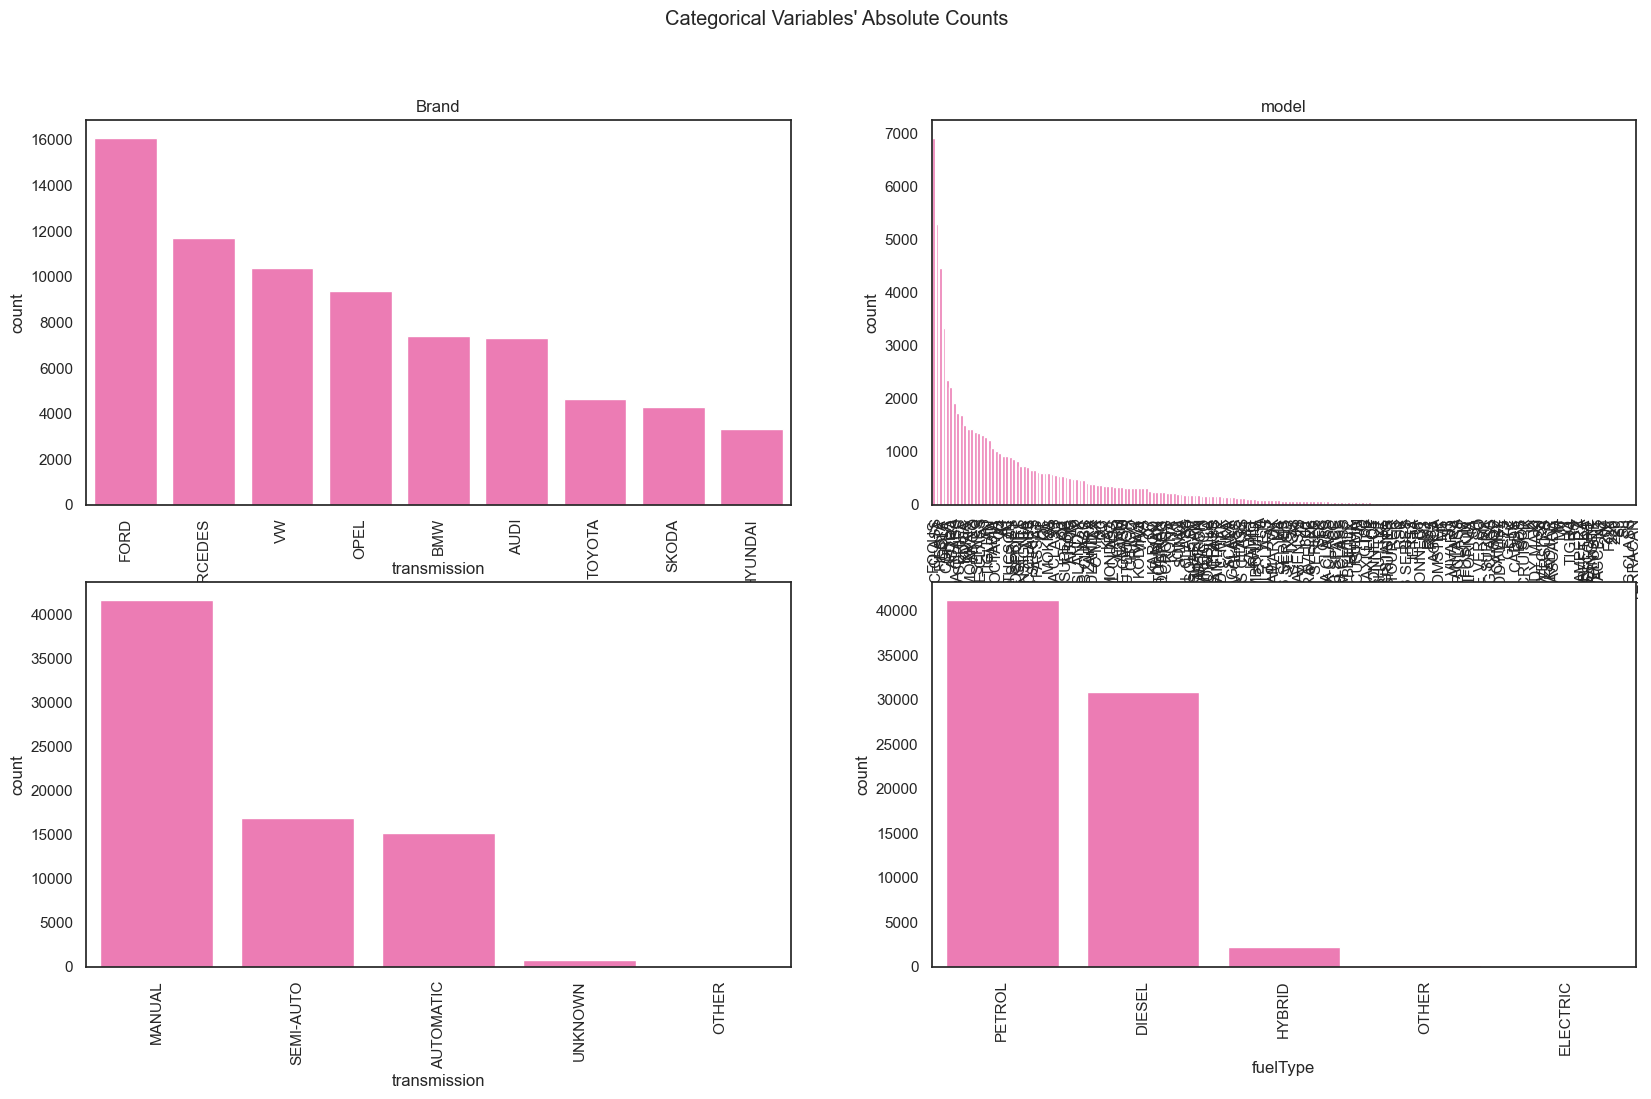

In [48]:
sns.set(style="white")

fig, axes = plt.subplots(
    2, 
    ceil(len(categorical_features) / 2), 
    figsize=(20, 11)
    )

for ax, feat in zip(axes.flatten(), categorical_features):
    sns.countplot(x=df_train[feat], ax=ax, 
                  order=df_train[feat].value_counts().index, color = 'hotpink') 
    ax.set_title(feat)
    ax.tick_params(axis='x', rotation=90)  # roda os labels no eixo x


plt.suptitle("Categorical Variables' Absolute Counts")
plt.show()

### Fix Numerical Variables

In [64]:
def correct_numerical_columns(df):
    numeric_columns = ['year',  'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
    for column in numeric_columns:
        df.loc[df[column] < 0, column] = np.nan
        
    df.loc[df['paintQuality%']>100, 'paintQuality%'] = np.nan

    df.loc[df['year'] > 2020, 'year'] = np.nan

    df.loc[df['previousOwners'] % 1 != 0] = np.nan

    return df

In [65]:
df_train[df_train['carID'].isna()]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage


In [66]:
df_train = correct_numerical_columns(df_train)
df_train

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512.0,VW,GOLF,2016,22290.0,SEMI-AUTO,28421.0,PETROL,NaN,11.417268,2.0,63.0,4.0,0.0
1,53000.0,TOYOTA,YARIS,2019,13790.0,MANUAL,4589.0,PETROL,145.0,47.900000,1.5,50.0,1.0,0.0
2,6366.0,AUDI,Q2,2019,24990.0,SEMI-AUTO,3624.0,PETROL,145.0,40.900000,1.5,56.0,4.0,0.0
3,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10062.0,BMW,2 SERIES,2019,22995.0,MANUAL,1000.0,PETROL,145.0,42.800000,1.5,97.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194.0,MERCEDES,C CLASS,2015,13498.0,MANUAL,14480.0,PETROL,125.0,53.300000,2.0,78.0,0.0,0.0
75969,6265.0,AUDI,Q3,2013,12495.0,SEMI-AUTO,52134.0,DIESEL,200.0,47.900000,2.0,38.0,2.0,0.0
75970,54886.0,TOYOTA,AYGO,2017,8399.0,AUTOMATIC,11304.0,PETROL,145.0,67.000000,1.0,57.0,3.0,0.0
75971,860.0,AUDI,Q3,2015,12990.0,MANUAL,69072.0,DIESEL,125.0,60.100000,2.0,74.0,2.0,0.0


In [52]:
df_train['model'].mode()

0    FOCUS
Name: model, dtype: object

In [53]:
def just_mode(x):
    return x.mode()[0]


df_train.groupby('hasDamage', dropna=False).agg({
    'price': 'median',
    'year' : 'median',
    'mileage' : 'median',
    'previousOwners' : 'median',
    'model' : just_mode
})

,price,year,mileage,previousOwners,model
hasDamage,,,,,
0.0,14698.0,2017.0,17440.0,2.0,FOCUS
NaN,14798.0,2017.0,16489.5,2.0,FOCUS


In [54]:
df_train[df_train['hasDamage'].isna()]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
62,46419,MERCEDES,A CLASS,2020,26500.0,SEMI-AUTO,3500.0,DIESEL,150.0,56.5,2.0,64.0,3.0,NaN
89,28739,FORD,NaN,2015,7099.0,MANUAL,74176.0,DIESEL,NaN,NaN,1.5,84.0,2.0,NaN
219,1768,AUDI,Q3,2020,35990.0,SEMI-AUTO,6000.0,DIESEL,145.0,47.1,2.0,48.0,NaN,NaN
240,33860,HYUNDAI,TUCSON,2017,14600.0,MANUAL,30165.0,DIESEL,30.0,61.7,1.7,55.0,4.0,NaN
304,50236,SKODA,OCTAVIA,2014,8495.0,MANUAL,65299.0,DIESEL,0.0,74.3,1.6,37.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75761,43016,MERCEDES,C CLASS,2019,32899.0,SEMI-AUTO,4378.0,DIESEL,NaN,NaN,2.0,49.0,0.0,NaN
75788,56250,OPEL,NaN,2019,15495.0,MANUAL,3129.0,PETROL,145.0,39.2,1.4,49.0,0.0,NaN
75851,2693,AUDI,A3,2015,6793.0,MANUAL,130000.0,DIESEL,0.0,74.3,1.6,51.0,3.0,NaN
75858,62623,OPEL,MOKKA X,2019,14995.0,MANUAL,10.0,PETROL,145.0,39.2,1.4,NaN,0.0,NaN


In [61]:
df_train[(df_train['model'] == 'ZAFIRA') & (df_train['previousOwners']==2) & (df_train['year'] == 2017) & ( df_train['mileage'] < 33000) & ( df_train['mileage'] > 28000)]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
2234,59709,OPEL,ZAFIRA,2017,11999.0,MANUAL,31608.0,PETROL,145.0,41.5,1.4,53.0,2.0,NaN
16417,63039,OPEL,ZAFIRA,2017,10798.0,MANUAL,29133.0,PETROL,145.0,41.5,1.4,90.0,2.0,0.0
26376,62618,OPEL,ZAFIRA,2017,11995.0,MANUAL,28327.0,PETROL,145.0,41.5,1.4,32.0,2.0,NaN
61959,65307,OPEL,ZAFIRA,2017,10050.0,MANUAL,32898.0,PETROL,145.0,41.5,1.4,85.0,2.0,0.0


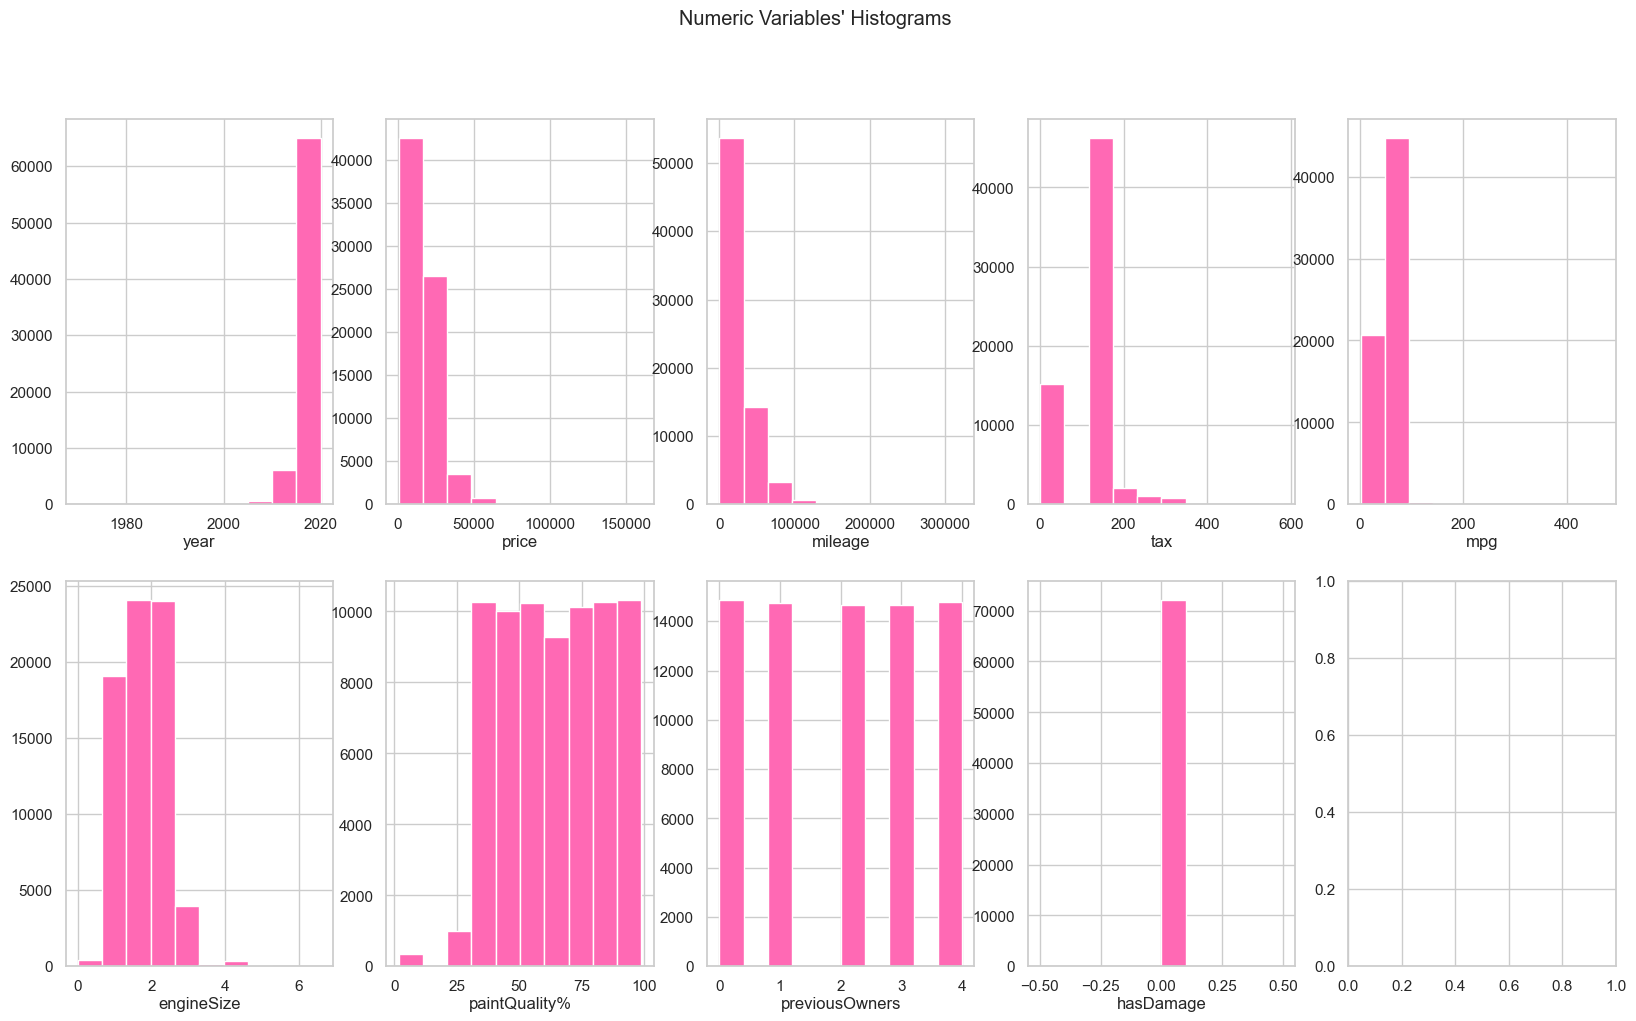

In [69]:
sns.set_style('whitegrid')

# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_features) / 2 ), figsize = (20, 11))

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(df_train[feat], color = 'hotpink')
    ax.set_title(feat, y = -0.13)

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Histograms")

plt.show()

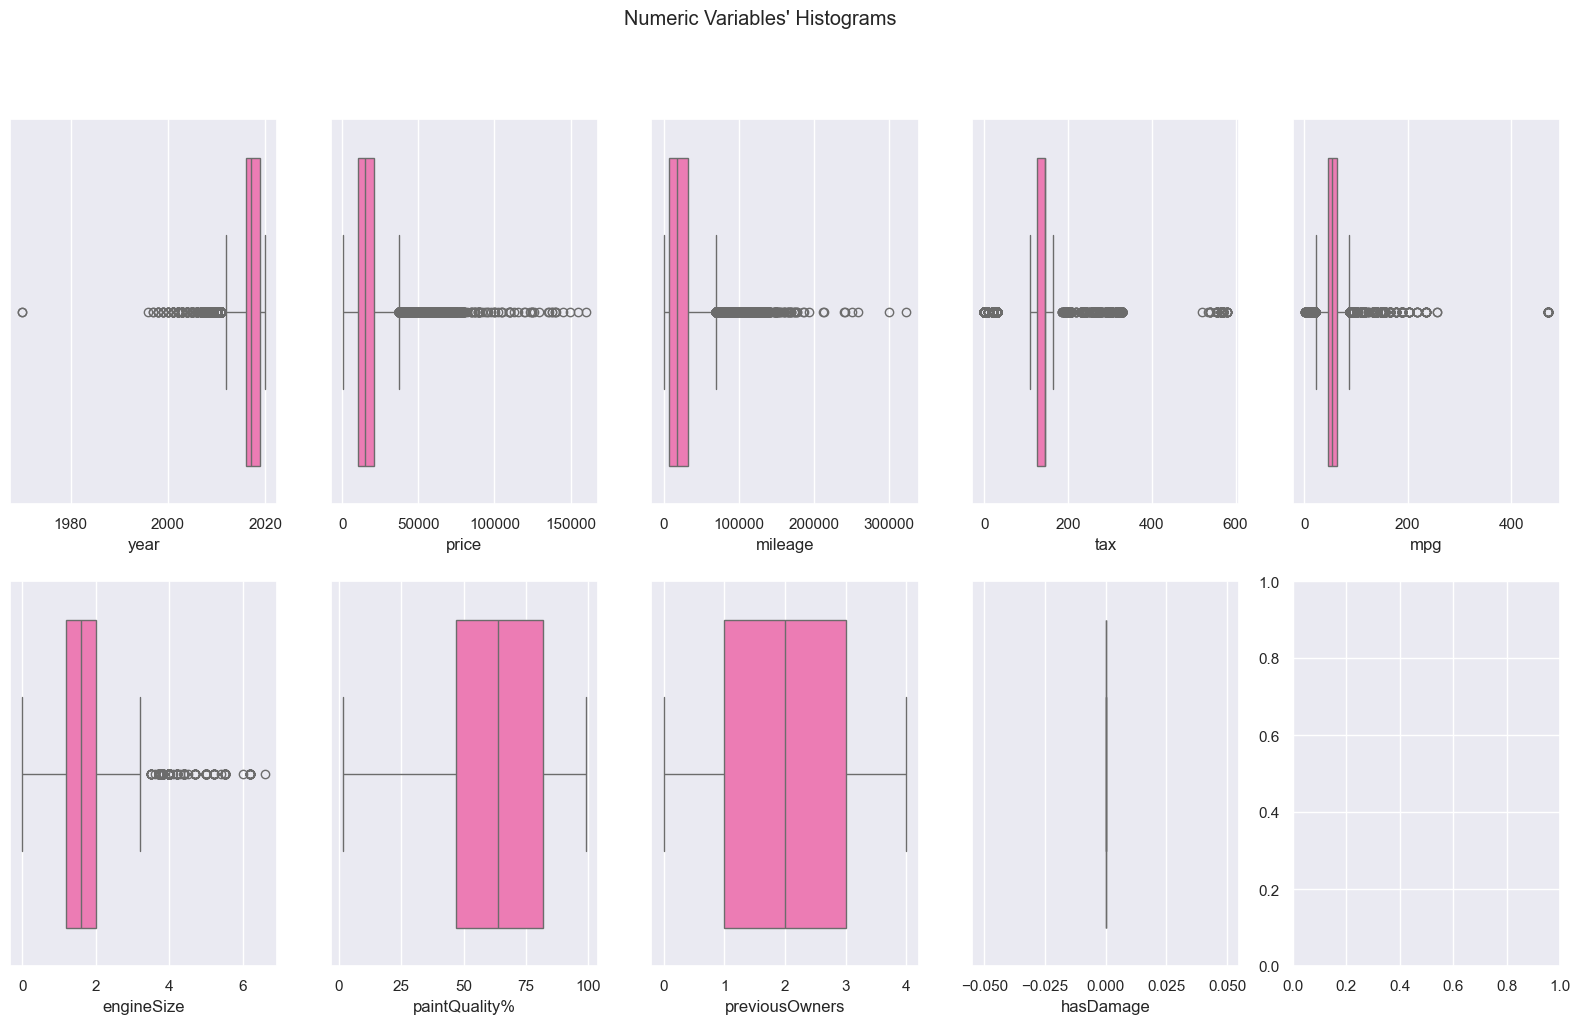

In [68]:
sns.set()

# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numeric_features) / 2 ), figsize = (20, 11))

for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=df_train[feat], ax=ax, color='hotpink')

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Histograms")

plt.show()

In [62]:
df_train['year'].value_counts()

year
2019    20271
2017    16146
2016    11502
2018    10304
2015     5733
2020     3174
2014     2930
2013     1902
2012      499
2010      483
2011      383
2009      265
2008      158
2007      123
2005       64
2006       62
2004       35
2003       29
2002       25
2001       15
2000        6
1998        5
1999        5
1970        2
1997        2
1996        1
Name: count, dtype: Int64

In [67]:
df_train['previousOwners'].value_counts()

previousOwners
0.0    14879
4.0    14763
1.0    14754
3.0    14649
2.0    14644
Name: count, dtype: int64

Electric cars have a similar thing to mpg, mpge that usualyy ranges between 90-135. Mpg usually ranges 10-80.

How to deal with NA:
- Pssamos as observações negativas e floats de previous Owners para NA é um erro sistemético, igual para todos
- Em engine size passar os 0 e os negativos para NA  e subtituir pelo engineSizde de outra observação desse modelo.
- Os problemas de tax, millage e de mpg estão concentrados em Ford e Mercedes, nos mesmos modelos, vamos por em NA
- Ano arrendondamos os valores, assumimos que os decimais são a parte do ano correspondente a meses, usamos floor
- ver relacao de has damage com o preço, as distribuições ão super parecidas, não parece haver distinção de 0 e NA. Possivelmente fazer por coluna.
- ver correlações de variáveis categóricas e numericas
- para observações com NA em model e brand ambos e nao haver grande correlação com model e brand com outras variáveis, para NA em model vemos a moda na mesma brand, para NA em brand vemos o mesmo model na coluna e escolhemos.
- NA de ano fazer KNN de mileage, fazes a mediana dos anos e arredondas.
- milage agrupar por ano e fazer a mediana 
- para trasmission agrupamos por modelo e ver a moda
- fuelType agrupamos pelo modelo e ver a moda
- tax agrupar pelo ano e ver a mediana
- mpg agrupar pelo modelo e ver a mediana
- engineSize agrupar pelo modelo e ver a mediana
- paintQuality KNN da mileage e ver a mediana 
- Previous Owners KNN da mileage e ver a mediana
